##### Nathan Kosoi Lamont

In [2]:
using Colors, Images, FileIO

include("src/RectangularRegionV1.jl")
include("src/ColorUtils.jl")

linterpRGBA (generic function with 1 method)

### Curva de Hilbert

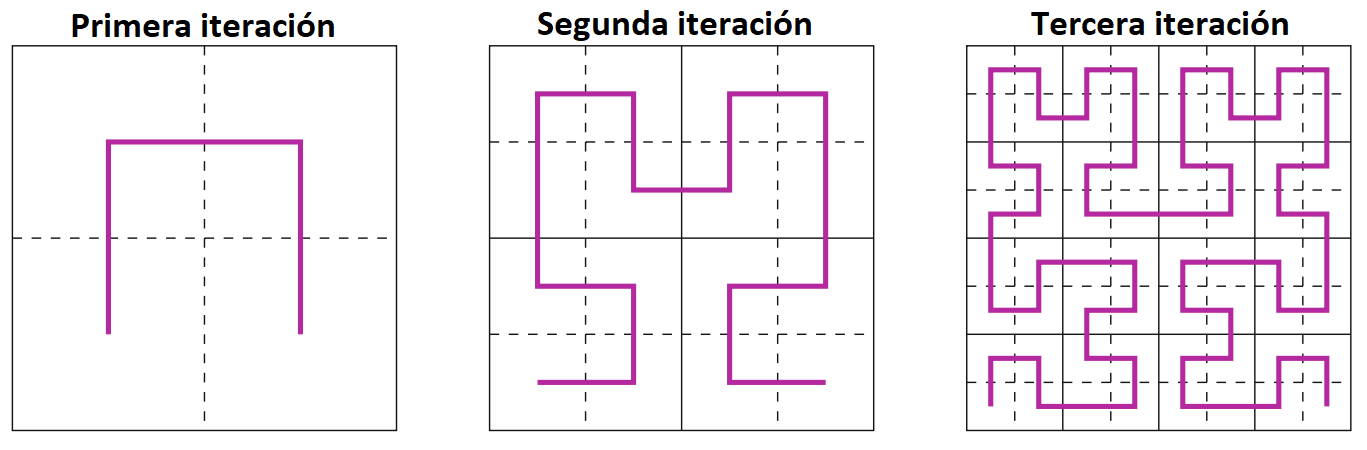

In [11]:
load("img/Hilbert123.png")

Podemos observar que hay un proceso recursivo en la creación de esta curva. Empezamos dividiendo en 4 el cuadrado unitario, de ahí unimos los puntos medios de cada cuadrante en un orden particular este orden nos define una matriz de 2x2, específicamente la matriz $\begin{pmatrix}
 2&3  \\
 1&4  \\
\end{pmatrix}$.
Para la siguiente iteración, dividimos el cuadrado unitario en 4 cuadrantes, cada uno de estos cuadrantes tendrá 4 cuadrantes a su vez, donde el cuadrante I tiene como entradas la matriz previamente obtenida, sumándole a cada entrada $\frac{2*4^{2}}{4}$. El cuadrante II tiene la matriz previamente obtenida sumándole a cada entrada $\frac{1*4^{2}}{4}$. El cuadrante III tiene la matriz previamente obtenida, pero reflejada por la diagonal perpendicular a la diagonal principal (Denotemos este tipo de transposición como $\tilde{\tau}$). El cuadrante IV es la matriz previamente obtenida, pero transpuesta y en cada entrada sumándole $\frac{3*4^{2}}{4}$.

Esto nos da un claro patrón recursivo, si en el paso $N$ obtenemos una matriz $A$, el paso $N+1$ constará de la siguiente matriz:
\begin{pmatrix}
 A+\frac{1*4^{2}}{4}&A+\frac{2*4^{2}}{4}  \\
 A^{\tilde{\tau}}&A^{\tau}+\frac{3*4^{N}}{4}  \\
\end{pmatrix}

No olvidemos que cada entrada de la matriz representa el orden en que la curva recorre los cuadrantes para llegar a ese punto, es decir, si un cuadrante tiene el número k, es porque dicho cuadrante es el k-ésimo en ser recorrido.

Podemos calcular $A^{\tilde{\tau}}$ con el siguiente código:

In [12]:
function trans2(matriz)
    k=size(matriz)[1]
    new_mat=zeros(size(matriz))
    for i=1:k
        for j=1:k

            new_mat[i,j]=matriz[k+1-j,k+1-i]

        end


    end
    return new_mat
end

trans2 (generic function with 1 method)

##### Programación de la curva de Hilbert

Empecemos creando el código para calcular la matriz de orden. Este codigo es, como era de esperarse, una función recursiva:

In [13]:
function crear_matriz_orden(num_iteraciones)
    long=Int(2^num_iteraciones) #la matriz de orden tendra dimensión (long,long)
    matriz=zeros(long,long)
    caso_base=[2 3;1 4]
    
    if num_iteraciones==1
        
        return caso_base
        
    else
        A = crear_matriz_orden(num_iteraciones-1) #paso recursivo
        
        matriz[1:Int(long/2),1:Int(long/2)]=A.+4^(num_iteraciones-1)#cuadrante arriba izquierda
        matriz[1:Int(long/2),Int(long/2)+1:Int(long)]=A.+2*4^(num_iteraciones-1)#cuadrante arriba derecha
        matriz[Int(long/2)+1:long,1:Int(long/2)]=trans2(A) #cuadrante abajo izquierda
        matriz[Int(long/2)+1:long,Int(long/2)+1:long]=transpose(A).+3*4^(num_iteraciones-1) #cuadrante abajo derecha
    end
    
    
    return matriz
end

crear_matriz_orden (generic function with 1 method)

Una vez que tenemos una matriz de orden, queremos convertir esto a un vector que nos simplifique definir la trayectoria que seguira la curva que vamos a dibujar, para eso es el siguiente código:

In [14]:
function matriz_to_vector_orden(matriz_orden)
    
    k=size(matriz_orden)[1]
    p0=[k,1] #Por construcción, el primer punto de la curva de hilbert siempre estará hasta abajo a la izquierda
    vector_orden=[]   #aquí estará la información de como se recorre la matriz
    
    for i=1:k^2-1 
    #para cada iteración checaré si el número siguiente está abajo, a la izquierda o arriba, el primer punto será [k,1]
        #en cada iteración reasignaré p0 al punto siguiente.
    
    #inicializo variables
    tauIz=0 
    tauDe=0
    tauAr=0
    tauAb=0

        if p0[1]!=k
            ##checar hacia abajo
            tauAb=matriz_orden[(p0+[1,0])[1],(p0+[1,0])[2]]
            
        end
            
        if p0[2]!=1
            ##checar hacia la izquierda
            tauIz=matriz_orden[(p0+[0,-1])[1],(p0+[0,-1])[2]]

        end
            
        if p0[2]!=k
            ##checar hacia la derecha
            tauDe=matriz_orden[(p0+[0,1])[1],(p0+[0,1])[2]]
        end
        
        if p0[1]!=1
            ##checar hacia arriba
            tauAr=matriz_orden[(p0+[-1,0])[1],(p0+[-1,0])[2]]
            
        end
        
        if tauAb==i+1
            p0=p0+[1,0]
            push!(vector_orden,"abajo")

            
        elseif tauAr==i+1 
            p0=p0+[-1,0]
            push!(vector_orden,"arriba")

            
        elseif tauIz==i+1
            p0=p0+[0,-1]
            push!(vector_orden,"izquierda")

            
        elseif tauDe==i+1
            p0=p0+[0,1]
            push!(vector_orden,"derecha")
            
        end
            
            
        
    end
    
    return vector_orden
end

matriz_to_vector_orden (generic function with 1 method)

Por último, definamos las funciones necesarias para crear un dibujo dada una matriz de orden.

In [15]:
function colorear!(matriz, p_i, p_f) 
    #Dada una matriz y dos puntos colineales de la matriz
    
    p_i=round.(Int,p_i)
    p_f=round.(Int,p_f)
    
    
    if p_i[1]==p_f[1]
        #colorear en horizontal
        if p_f[2]>p_i[2] #de izquierda a derecha
            for i=p_i[2]:p_f[2]
                matriz[p_i[1],i]=1
            end

        elseif p_f[2]<p_i[2] #de derecha a izquierda
            for i=p_f[2]:p_i[2]
               matriz[p_i[1],i]=1 
            end

        end
    elseif p_i[2]==p_f[2]
        #colorear en vertical
        if p_f[1]>p_i[1] #de abajo hacia arriba
            for i=p_i[1]:p_f[1]
                matriz[i,p_i[2]]=1

            end

        elseif p_f[1]<p_i[1] #de arriba hacia abajo
            for i=p_f[1]:p_i[1] 
                matriz[i,p_i[2]]=1

            end
        end

    end
end

function coloreo_dado_orden(iteracion,vec_orden,lenIm=256)
    #Los elementos de vec_orden deben ser "arriba","abajo","izquierda","derecha"
    #Si la longitud de la imagen es muy pequeña, puede no funcionar el código, también se recomienda que sea potencia de 2
    longitud_imagen=lenIm
    curva=zeros(longitud_imagen,longitud_imagen)  
    iter=iteracion
    orden=vec_orden
    total=4^iter

    distancia=1/2^iter
    p0=([longitud_imagen,1]+longitud_imagen*[-0.5*distancia,0.5*distancia])
    puntos=[p0]
    for i in orden
    #Para cada iteración, coloreare una distancia hacia la dirección que indica el vector de orden
        if i=="arriba"
            p0=p0+longitud_imagen*[-distancia,0]
            push!(puntos,p0)

        elseif i=="derecha"
            p0=p0+longitud_imagen*[0,distancia]
            push!(puntos,p0)

        elseif i=="abajo"
            p0=p0+longitud_imagen*[distancia,0]
            push!(puntos,p0)

        elseif i=="izquierda"
            p0=p0+longitud_imagen*[0,-distancia]
            push!(puntos,p0)


        end
    end

    for i=1:total-1
       colorear!(curva,puntos[i],puntos[i+1]) 

    end

    Gray.(curva)
    
end

coloreo_dado_orden (generic function with 2 methods)

Ensamblemos todas las piezas y pongamos a prueba nuestro código

In [16]:
function CurvaHilbert(iteraciones,tamano=512)#tamaño tiene que ser potencia de 2, y suficientemente grande
    coloreo_dado_orden(iteraciones,matriz_to_vector_orden(crear_matriz_orden(iteraciones)),tamano)
end

CurvaHilbert (generic function with 2 methods)

##### Primera iteración

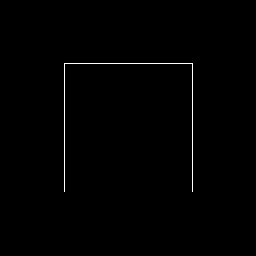

In [17]:
CurvaHilbert(1,256)

##### Segunda iteración

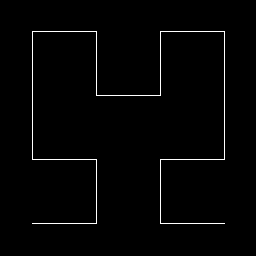

In [18]:
CurvaHilbert(2,256)

##### Tercera iteración

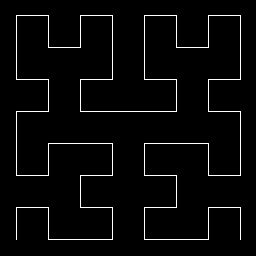

In [19]:
CurvaHilbert(3,256)

##### Cuarta iteración

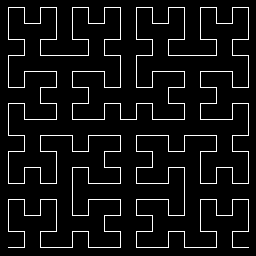

In [20]:
CurvaHilbert(4,256)

##### Quinta iteración

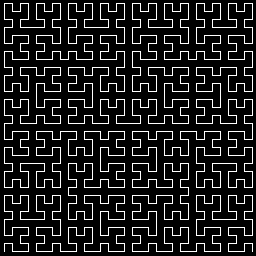

In [21]:
CurvaHilbert(5,256)

##### Sexta iteración

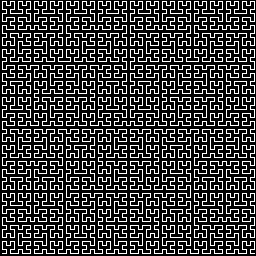

In [22]:
CurvaHilbert(6,256)

##### Séptima iteración

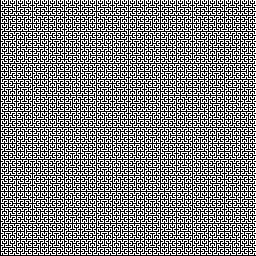

In [23]:
CurvaHilbert(7,256)

### Conclusiones sobre la curva de Hilbert

De momento hemos visto solo iteraciones de la curva de hilbert, sin embargo, la curva de Hilbert, intuitivamente, es el resultado de llevar este proceso al infinito. Como podemos observar, para cada iteración, la curva se aproxima a llenar el cuadrado. Sin embargo, ¿cómo sabemos que en verdad esta curva es sobreyectiva?

Esto lo podemos deducir del hecho de que cada punto en el cuadrado puede ser aproximado por una sucesión de subcuadrados anidados, y como el espacio es Compacto, esta sucesión converge al único punto que es precisamente el cual define la función de la curva de Hilbert.

### Observaciones adicionales

¿Es la curva de hilbert un fractal? Esto dependerá de la definición que se tenga de fractal. En definitiva es en cierto sentido autosimilar pues fue construida de esa forma. Pero si pensamos que la curva es la función, entonces no tiene, de primeras y bajo nuestra base teórica inicial, mucho sentido hablar de funciones fractales. Por otro lado, ¿es la imagen de la función un fractal? Claramente es el atractator de un SFIH, pero, no olvidemos lo que acabamos de demostrar, ¡la imagen de la función es precisamente el cuadrado unitario! cuya dimensión topológica es 2 al igual que su dimensión fractal. Su frontera tiene dimensión topológica 1, lo mismo que su dimensión fractal. Por lo tanto, no cumple ese requerimiento de la definición de fractal.

Algo que es importante de observar es que el código hace mucho énfasis en que la matriz donde se dibuje sea de dimensión $(2^n,2^n)$, por lo que si la dimensión donde se dibuja es distinta, pueden obtenerse curvas parecidas a la de hilbert, pero geométricamente distintas:

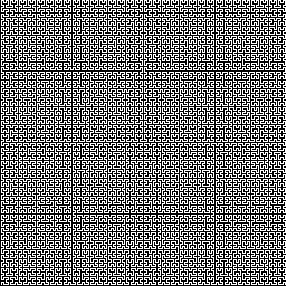

In [24]:
CurvaHilbert(7,286)

In [25]:
# Fin